In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import somoclu
import os, sys
from tqdm import tqdm
import rasterio

Using the Discrete Cosine Transform to compress feature space
=============================================================

Introduction
------------

Currently, I've been working on a particularly tricky machine learning task; broadly stated, I'm trying to catergorize unlabled image tiles. Unlike famous problems involving cats, dogs, and cars *a la imagenet*, my training data is landforms--digital elevation models of terrain, in 100 meter by 100 meter patches at 0.5 meter resolution. A few consquences to this: 

 - First, it doesn't fit into *a priori* neat catagories. I'd like to cluster like landforms together in space, but I don't know what the final labelings will be. This makes for a very general and ill posed question...and hence a fairly difficult one to answer. I've resolved to solve, or at least address, this problem with deep learning--specifically using Self Organizing Maps, or SOM's.  


 - Second, the feature space is enormous, which produces both computational problems, and also reduces the sensativity of the analysis above when encountering high frequency spatial features in the training data. On the computational side, simply flattening the 200 by 200 raster tiles gives a 40,000 dimentional feature space. There are two pontential fixes for this: corsen the images via the DCT, or encode tiles into a low dimentional feature space via an autoencoder. I'll address the DCT meathod in this post, and explore the autoencoder solution at a later date.
 
Data
----

My data for this consists of 212,534 image tiles that look like this:

In [3]:
store = pd.HDFStore('/Users/grigsbye/Desktop/full_wf.h5','r')
conv = store['conv']
store.close()

In [5]:
example = rasterio.open('Desktop/all_tiles_april/' + conv.index[163] + '.tif')

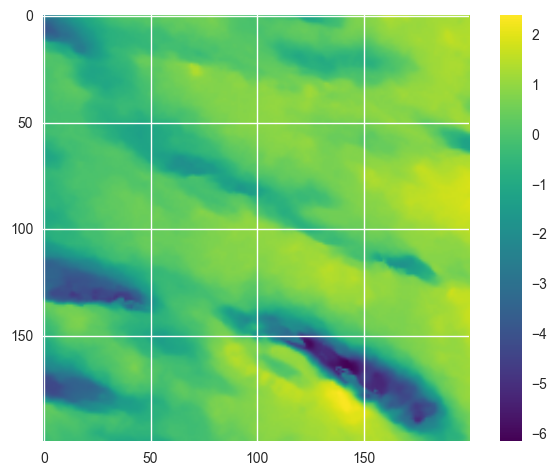

In [10]:
imshow(example.read()[0], cmap='viridis')
colorbar()

The colorbar denotes meters elevation relief, while the x and y axis refers to cells across each dimention.

The Discrete Cosine Transform (DCT) versus the FFT
--------------------------------------------------

The DCT is similar to the more famous Fourier transform in that the image is decomposed into a set of trigonometric functions, but has a number of distinguishing characteristics. First and foremost, it is not an exact transformation. Numpy/Scipy don't have a 2D varient of the DCT, but we can write functions that will implement a 2D transform fairly easily: 

In [30]:
# http://stackoverflow.com/questions/40104377/issiue-with-implementation-of-2d-discrete-cosine-transform-in-python
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.dct.html
# http://dx.doi.org/10.1109/TASSP.1980.1163351

from scipy.fftpack import dct, idct
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho') # TODO: original source for these functions

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

First, the more famous FFT:

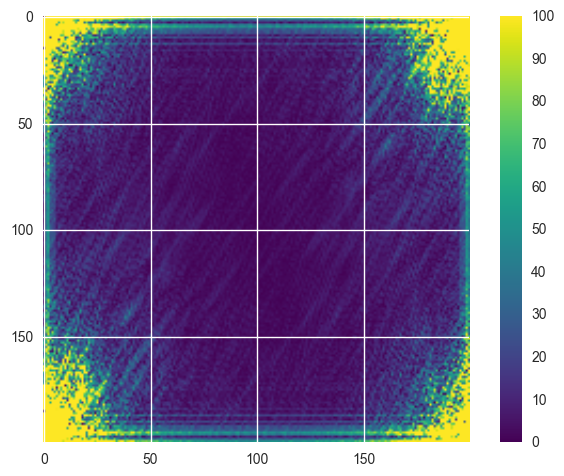

In [17]:
fftexample = np.fft.fft2(example.read()[0])
imshow(np.abs(fftexample), cmap='viridis', vmin=0, vmax=100)
colorbar()

Note that to show the FFT, we have to call the absolute value function; this is because the FFT gives a complex array, with the real portion signifying magnatude, and the imaginary part signifyign phase. The transform itself projects these value into the frequency space, with central values showing low frequency components, and values on the edges showing high frequency componets. I won't go into the specifics here, but low and high pass circular filters are typically applied to the FFT, resulting in various convolutions and smoothing opperations apon calling the inverse FFT function (ifft). For our purposes, I'll simply show that the transform is invertable:

(2.3624348462723546e-14, 5.9060871156808869e-19, 1.4654943925052066e-14)


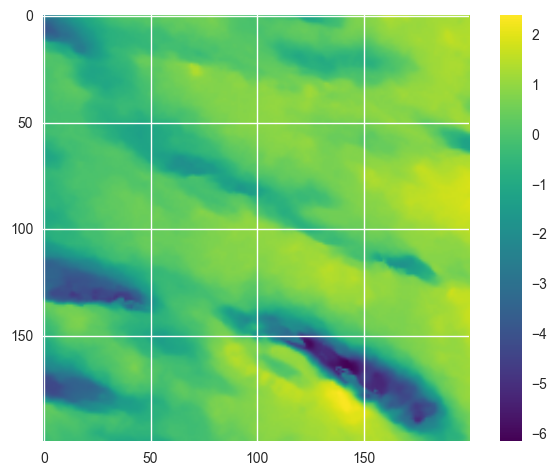

In [28]:
inversefft = np.fft.ifft2(fftexample)
imshow(inversefft.real, cmap='viridis')
colorbar()
print((np.sum(inversefft.real - example.read()[0]),
       np.mean(inversefft.real - example.read()[0]),
       np.max(inversefft.real - example.read()[0])))

The inverse of the FFT gives the orginal image to within machine precision.

Now, let's compare with the DCT:

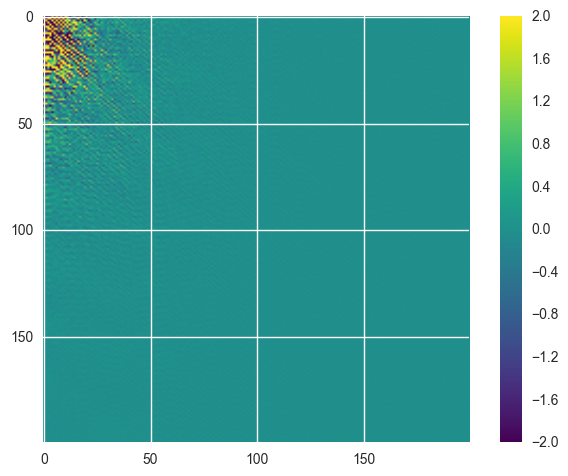

In [31]:
dctexample = dct2(example.read()[0])
imshow(dctexample, cmap='viridis', vmin=-2, vmax=2)
colorbar()

Note that we don't call absolute value on the transform, as all of our data is already floating point. Also note that the 'energy' of the image is concentrated in the upper left of the image. Looking at the inverse:

(0.00021437835, 5.3594587e-09, 1.3113022e-06)


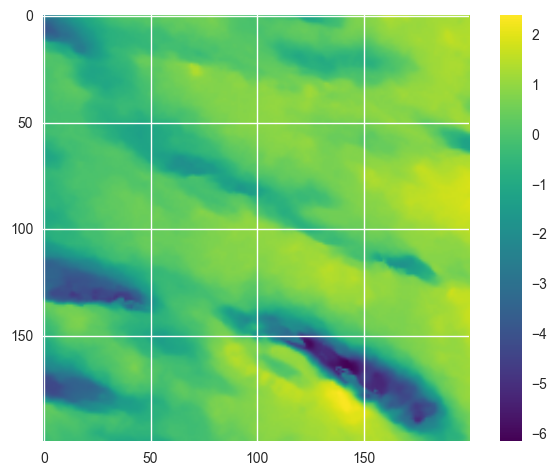

In [37]:
inversedct = idct2(dctexample)
imshow(inversedct, cmap='viridis')
colorbar()
print((np.sum(inversedct - example.read()[0]),
       np.mean(inversedct - example.read()[0]),
       np.max(inversedct - example.read()[0])))

Note that the inverse transform is orders of magnatude less accurate than the IFFT; we're well outside of machine precision disagreement here. Plotting the differences makes it even more explicit:

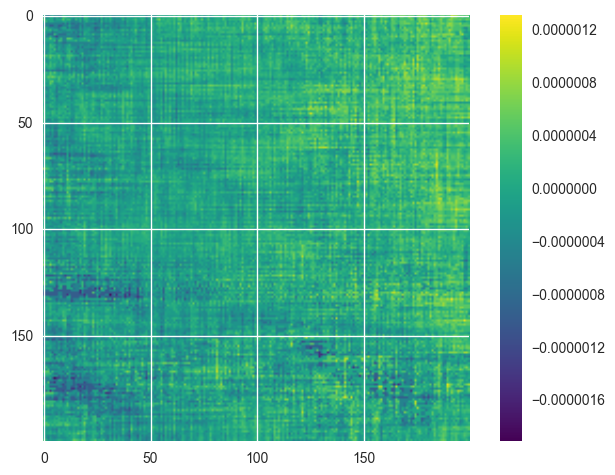

In [38]:
imshow(inversedct-example.read()[0], cmap='viridis')
colorbar()

Keeping in mind that the orginal units for the terrain tile are meters, this level of imprecision is fine; we're looking at a micron displacement in the DEM at worse, which is perfectly fine. In fact, we can even execpt more imprecision...

Reducing Dimentionallity with the DCT
--------------------------------------

Keeping in mind that these tiles will be fed to a neural network as a flattened vectors, 200 by 200 translates into a 40,000 dimention feature space. That's quite large, and the compute time scales unfavorably. We can compress our image if we're willing to accept more imprecision by simply taking a portion of the DCT starting at the upper left hand corner:

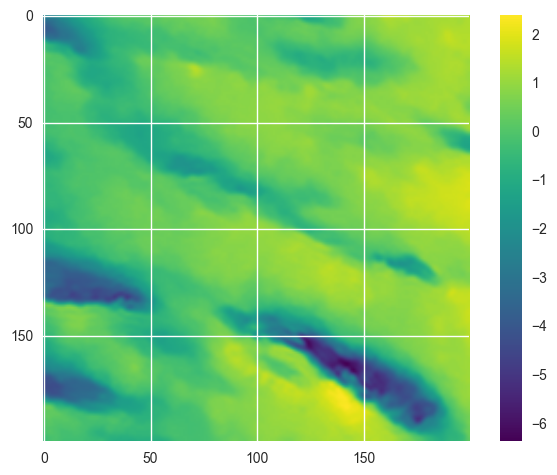

In [39]:
reducedDCT = np.zeros_like(example.read()[0])
reducedDCT[:100,:100] = dctexample[:100,:100] # Grabbing upperleft quarter of full DCT
reduced_inverseDCT = idct2(reducedDCT)
imshow(reduced_inverseDCT, cmap='viridis')
colorbar()

...looks pretty similar. How much precision have we given up?

(3.0010938e-09, 5.9522688e-05)
0.935675
0.019075
0.0019


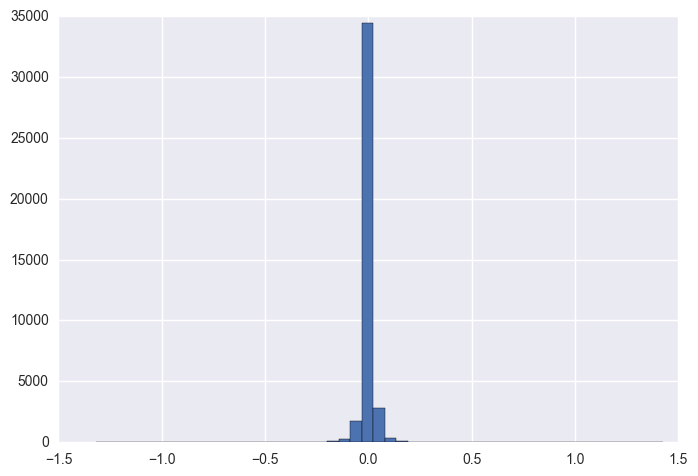

In [49]:
hist(np.ravel(reduced_inverseDCT - example.read()[0]),50)
print((np.mean(reduced_inverseDCT - example.read()[0]), np.median(reduced_inverseDCT - example.read()[0])))
print(sum(np.abs(reduced_inverseDCT - example.read()[0]) > 0.001)/40000.0)
print(sum(np.abs(reduced_inverseDCT - example.read()[0]) > 0.1)/40000.0)
print(sum(np.abs(reduced_inverseDCT - example.read()[0]) > 0.3)/40000.0)

The *vast* majority of pixels are perturbed between a micron and a half a millimeter, with less then 2% perturbed more than 10 cm. For my purposes, 10cm accuracy is fine-- the data was only collected with confidence to 15cm. There are a very small minority of pixels (< 0.2%) that are very inaccurate though...that is to say errors greater than 30cm, which is a bit worrying. Where are these outlyers?

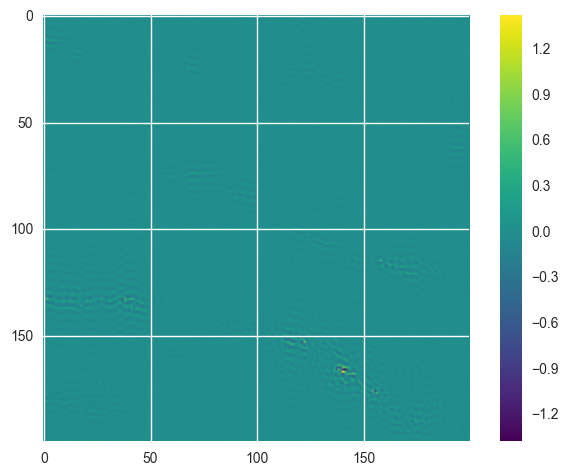

In [50]:
imshow(reduced_inverseDCT - example.read()[0], cmap='viridis')
colorbar()

...It looks like we're losing detail within the fissures. One thing to keep in mind is that spatially, an error in elevation is indistinguishable from an error in location. That is, if the starting point of the decent into the fissure or crevasse is moved to an adjacent pixel, the numeric error will be quite large even though we are reproducing the image with high fidelity.

In short, we've reduced our orginal feature space by 75% -- from 40,000 dimentions, to 10,000 dimentions -- with minor impact on the information content of the training tiles. This data will be going into a SOM anyway, and running the SOM at full resolution versus the reduced resolution puts the above tile in the same location with the same nieghbors. What actaully goes into the neural net is:

In [52]:
inputVectorSmall = np.ravel(dctexample[:100,:100])
np.shape(inputVectorSmall)

(10000,)

...instead of:

In [53]:
inputVectorLarge = np.ravel(dctexample)
np.shape(inputVectorLarge)

(40000,)

In either case, the DCT is loaded. We could load the orginal image (flattened)

In [54]:
 conv.index[163]

'0040d147b8fc19c24398cd289962469c92349cb4cfe12bb97a7dd2287777f1d7'

In [ ]:
~Desktop/all_tiles_april/0040d147b8fc19c24398cd289962469c92349cb4cfe12bb97a7dd2287777f1d7.tif